# ResNet Autoencoder (AE) for ECAL DQM 
EB Occupancy

In [1]:
import numpy as np
np.random.seed(0)
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import *

import time
import os, glob
# Specify which gpuid to use
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedLocator
%matplotlib inline

Do a test read of the input data:

In [2]:
f = pq.ParquetFile('DATA/500ev_ECALDQM_run325170.parquet')
print(f.schema)
print(f.metadata)

run: INT64
PU: DOUBLE
lumi_delivered: DOUBLE
EBOccupancyTask_EBOT_digi_occupancy.list.item.list.item: DOUBLE
lumi: DOUBLE
ls: INT64
 
  created_by: parquet-cpp version 1.3.1-SNAPSHOT
  num_columns: 6
  num_rows: 1203
  num_row_groups: 1203
  format_version: 1.0
  serialized_size: 710014


## Define pre-processing routines and any necessary plotting functions

In [3]:
plt.rcParams["figure.figsize"] = (8,6)

def plot_EB(img, vmin=0., vmax=1., cmap='gist_yarg', label='Normalized Occupancy', extend_edge=False): # cmap = 'jet'

    # Only plots single channel, single sample images
    img = img.squeeze()
    assert len(img.shape) == 2
    
    if extend_edge:
        ieta_max = 18
    else:
        img = img[1:-1,:] if img.shape[-2] > 34 else img
        ieta_max = 17
    
    fig, ax = plt.subplots()
    im = ax.imshow(img, vmin=vmin, vmax=vmax, cmap=cmap, origin='lower')
    ax.figure.colorbar(im, ax=ax, fraction=0.0228, pad=0.015, label=label)

    # By default, imshow() places tick marks at center of image pixel, 
    # so need to shift to the low side by 0.5 to match DQM convention
    # of ticks being placed on low edge of bin
    off = 0.5
    # Set image coordinates where ticks should appear...
    ax.set_xticks(np.arange(0,72+8,8)-off)
    ax.set_yticks(np.arange(0,(2*ieta_max)+ieta_max,ieta_max)-off)
    # then set what values should be displayed at these coordinates
    ax.set_xticklabels(np.arange(0,72+8,8))
    ax.set_yticklabels([-ieta_max,0,ieta_max])
    # Make ticks face inward
    ax.xaxis.set_tick_params(direction='in', which='major', length=6.)
    ax.xaxis.set_tick_params(direction='in', which='minor', length=3.)
    ax.yaxis.set_tick_params(direction='in', which='major', length=6.)
    ax.yaxis.set_tick_params(direction='in', which='minor', length=3.)

    # Plot supermodule boundaries. Need to apply same offset for plot()
    # Horizontal +/- eta boundary
    ax.plot([0-off,72-off],[ieta_max-off,ieta_max-off], linewidth=1., linestyle='--', color='black')
    # Vertical phi boundaries
    for iphi in np.arange(0,72,4):
        ax.plot([iphi-off,iphi-off],[0-off,(2*ieta_max)-off], linewidth=1., linestyle='--', color='black')

    plt.show()
    plt.close()

In [4]:
def apply_PU_corr(img):
    '''
    Function to correct occupancy for PU
    '''
    img = img/1.e3 # TODO: FIXME
    return img

In [5]:
def apply_anom_transform(img):
    '''
    User-defined function for applying anomaly transformation to good samples
    '''
    img[:,:17,:4] = 0. # TODO: FIXME
    return img

Do check on test data:

EB shape: (1, 34, 72)
EB shape: (1, 36, 72)
0.133 0.937


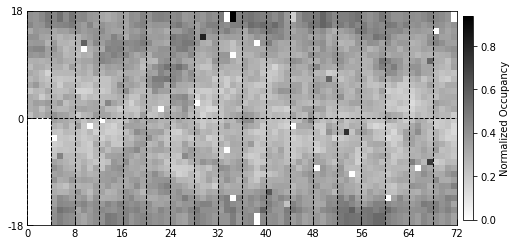

In [6]:
x = np.array(f.read_row_group(0).to_pydict()['EBOccupancyTask_EBOT_digi_occupancy'])
x = apply_PU_corr(x)
x = apply_anom_transform(x)
print('EB shape:',x.shape)
x = np.pad(x, ((0,0), (1,1), (0,0)), 'edge')
print('EB shape:',x.shape)
print(x[x>0.].min(), x.max())
plot_EB(x, vmax=x.max(), extend_edge=True)
#plot_EB(x, cmap='jet')

# Define input datasets

Define how "good" samples are to be read in

In [7]:
class ParquetDataset(Dataset):
    '''
    Define Dataset class for "good" samples.
    Occ vs PU correction to be applied here to obtain a normalized occupancy as a fn of PU
    '''
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        #self.cols = None # read all columns
        self.cols = ['EBOccupancyTask_EBOT_digi_occupancy.list.item.list.item']
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.float32(data['EBOccupancyTask_EBOT_digi_occupancy'][0]).reshape(-1,34,72)
        data['EBOccupancyTask_EBOT_digi_occupancy'] = apply_PU_corr(data['EBOccupancyTask_EBOT_digi_occupancy'])
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.pad(data['EBOccupancyTask_EBOT_digi_occupancy'], ((0,0), (1,1), (0,0)), 'edge')
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

Define how "anomaly" samples are to be read in

In [8]:
class ParquetDatasetAnom(Dataset):
    '''
    Define Dataset class for samples which are to be transformed into "anomalous looking"
    Occ vs PU correction to be applied here to obtain a normalized occupancy as a fn of PU
    User-defined anomaly transformation also applied here
    '''
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None # read all columns
        self.cols = ['EBOccupancyTask_EBOT_digi_occupancy.list.item.list.item']
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.float32(data['EBOccupancyTask_EBOT_digi_occupancy'][0]).reshape(-1,34,72)
        data['EBOccupancyTask_EBOT_digi_occupancy'] = apply_PU_corr(data['EBOccupancyTask_EBOT_digi_occupancy'])
        data['EBOccupancyTask_EBOT_digi_occupancy'] = apply_anom_transform(data['EBOccupancyTask_EBOT_digi_occupancy'])
        data['EBOccupancyTask_EBOT_digi_occupancy'] = np.pad(data['EBOccupancyTask_EBOT_digi_occupancy'], ((0,0), (1,1), (0,0)), 'edge')
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

Split data into training, validation, and anomaly sets

In [9]:
input_runs = glob.glob('DATA/500ev_ECALDQM_run*.parquet')
print('>> N input runs: %s'%len(input_runs))
assert len(input_runs) > 0

# Split input "good" dataset into training and validation sets
dset_good = ConcatDataset([ParquetDataset('%s'%r) for r in input_runs])
print('>> N good samples:',len(dset_good))
n_train, n_val = 1e3, 2e2
n_train, n_val = int(n_train), int(n_val)
print('>> N train samples:',n_train)
print('>> N val samples:',n_val)
assert n_train+n_val <= len(dset_good)
# Shuffle indices before making split
# Files may be ordered by run or LS which should not be learned
idxs = np.random.permutation(len(dset_good))
idxs_train, idxs_val = idxs[:n_train], idxs[-n_val:]

# Training set needs to be shuffled
sampler_train = sampler.SubsetRandomSampler(idxs_train)
loader_train = DataLoader(dataset=dset_good, batch_size=32, num_workers=10, sampler=sampler_train, pin_memory=True)

# Do not shuffle validation set so can compare same image from epoch to epoch
sampler_val = sampler.SequentialSampler(idxs[-n_val:])
loader_val = DataLoader(dataset=dset_good, batch_size=32, num_workers=10, sampler=sampler_val)

# Define anomalous images:
# Apply transformation on same samples as in validation set
dset_anom = ConcatDataset([ParquetDatasetAnom('%s'%r) for r in input_runs])
loader_anom = DataLoader(dataset=dset_anom, batch_size=32, num_workers=10, sampler=sampler_val)

>> N input runs: 1
>> N good samples: 1203
>> N train samples: 1000
>> N val samples: 200


# Evaluation function

Define what to do during the validation phase of the training. For instance, we can look at the original and AE-reconstructed image for some fixed sample at every epoch, and observe how the AE loss map between them changes during training.

In [10]:
def do_eval(ae, val_loader, epoch, dstr='EBOccupancyTask_EBOT_digi_occupancy', idx=0):
    loss_ = []
    now = time.time()
    for i, data in enumerate(val_loader):
        X = data[dstr].cuda()
        Xreco = ae(X)
        # Crop out padded rows at eta edges
        X, Xreco = X[...,1:-1,:], Xreco[...,1:-1,:]
        # By default, torch.mse_loss takes batch-averaged loss
        # During validation phase, want to know EB loss map for each sample (LS) in the batch
        # reduction='none' calculates loss on each *pixel* in image
        losses = F.mse_loss(Xreco, X, reduction='none')
        #losses = losses.view(losses.size()[0],-1).mean(dim=-1) # For calculating single loss per sample in batch
        loss_.append(losses.tolist())
        # To monitor progress from epoch to epoch, 
        # explicity plot original and AE-reconstructed images for idx-th sample in the first batch
        # then plot the loss map
        if i == 0:
            # Original image:
            print(' >> original image:')
            img = X[idx].cpu().numpy()
            plot_EB(img)
            # AE-reconstructed image
            print(' >> AE-reco image:')
            img_reco = Xreco[idx].detach().cpu().numpy()
            plot_EB(img_reco)
            # Loss map
            print(' >> loss map:')
            img_loss = F.mse_loss(Xreco[idx], X[idx], reduction='none').detach().cpu().numpy()
            plot_EB(img_loss, vmax=0.2, cmap='jet')

    now = time.time() - now
    loss_ = np.concatenate(loss_)
    
    s = '%d: Val loss:%f, MAE: %f, N samples: %d in %f min'%(epoch, loss_.mean(), (np.sqrt(loss_)).mean(), len(loss_), now/60.)
    print(s)
    return loss_

# Define AE model

Construct a baseline ResNet autoencoder for both encoding and decoding. During the decoding phase, run an inverse ResNet network (i.e. using transposed convolutions), trying as much as possible to follow the intermediate sizes of the encoding ResNet except going in reverse.

Define ResNet blocks for encoding and decoding

In [11]:
class ResBlock(nn.Module):
    '''
    For encoding, define the nominal resnet block
    '''
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = 2 if out_channels > in_channels else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

class ResBlockTranspose(nn.Module):
    '''
    For decoding, define the transposed resnet block, aka "de-convolution"
    '''
    def __init__(self, in_channels, out_channels, out_shape=None):
        super(ResBlockTranspose, self).__init__()
        self.upsample = 2 if in_channels > out_channels else 1
        self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=1)
        #self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)
        #self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=0)

        self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample)
        #self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample, padding=0)
        self.out_shape = out_shape

    def forward(self, x):
        residual = x
        
        if self.out_shape is None:
            out = self.convT1(x)
        else:
            out = self.convT1(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
        out = self.relu(out)
        out = self.convT2(out)

        if self.upsample > 1:
            if self.out_shape is None:
                residual = self.shortcutT(x)
            else:
                residual = self.shortcutT(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
            
        out += residual
        out = self.relu(out)

        return out

Define the full ResNet autoencoder module. NOTE: Getting the right dimensions on the decoding (upsampling) is tricky and adding unnecessary padding can potentially lead to dead spots in the AE-reco image... to be tuned.

In [12]:
class ResNetAE(nn.Module):
    '''
    Define the full ResNet autoencoder model
    '''
    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNetAE, self).__init__()

        self.fmaps = fmaps
        self.nblocks = nblocks
        self.in_channels = in_channels
        '''
        #7x7, s=2
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=7, stride=2, padding=1), nn.ReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[1], self.fmaps[1]*4*9) # 5x5
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(8,17))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        #self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=7, stride=2, padding=(0,1))
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=7, stride=2, padding=(1,1))
        self.dconv0_relu = nn.ReLU(inplace=True)
        '''
        '''
        #5x5, s=1
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=5, stride=1, padding=1), nn.ReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[1], self.fmaps[1]*9*18) # 5x5
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(17,35))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        #self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=7, stride=2, padding=(0,1))
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=5, stride=1, padding=(1,1))
        self.dconv0_relu = nn.ReLU(inplace=True)
        '''
        '''
        #3x3, s=1
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=3, stride=1, padding=1), nn.ReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[1], self.fmaps[1]*9*18) # 5x5
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(18,36))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        #self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=7, stride=2, padding=(0,1))
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=3, stride=1, padding=(1,1))
        self.dconv0_relu = nn.ReLU(inplace=True)
        '''
        #'''
        #3x3, s=1, down4/5
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=3, stride=1, padding=1), nn.ReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        self.elayer4 = self.block_layers(1, [fmaps[1],fmaps[2]], 'enc')
        self.elayer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[-1], self.fmaps[-1]*5*9) # 5x5
        self.dlayer5 = self.block_layers(self.nblocks, [fmaps[2],fmaps[2]], 'dec', out_shape=None)
        self.dlayer4 = self.block_layers(1, [fmaps[2],fmaps[1]], 'dec', out_shape=(9,18))
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(18,36))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        #self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=7, stride=2, padding=(0,1))
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=3, stride=1, padding=(1,1))
        self.dconv0_relu = nn.ReLU(inplace=True)
        #'''
        self.debug = False
        #self.debug = True

    def block_layers(self, nblocks, fmaps, state, out_shape=None):
        '''
        Convenience function: append several resnet blocks in sequence
        '''
        layers = []
        for _ in range(nblocks):
            if state == 'enc':
                layers.append(ResBlock(fmaps[0], fmaps[1]))
            else:
                layers.append(ResBlockTranspose(fmaps[0], fmaps[1], out_shape)) 
        return nn.Sequential(*layers)

    '''
    For VAE:
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    '''

    def forward(self, x):
        
        # Encoding
        if self.debug: print(x.size())
        if self.debug: print("Encode")
        x = self.econv0(x)
        if self.debug: print(x.size())
        x = F.max_pool2d(x, kernel_size=2)
        if self.debug: print(x.size())

        x = self.elayer1(x)
        if self.debug: print(x.size())
        x = self.elayer2(x)
        if self.debug: print(x.size())
        x = self.elayer3(x)
        if self.debug: print(x.size())
        x = self.elayer4(x)
        if self.debug: print(x.size())
        x = self.elayer5(x)
        if self.debug: print(x.size())
        
        # Bottleneck comes from GlobalMaxPool
        if self.debug: print("Maxpool-FC")
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        #if self.debug: print(x.size())
        x = x.view(x.size()[0], -1)
        if self.debug: print(x.size())
        
        '''
        For VAE:
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        '''
        
        # Expand bottleneck
        # Dimensions follow encoding steps in reverse, as much as possible
        x = self.fc(x) # expand
        if self.debug: print(x.size())
        #x = x.view(-1, self.fmaps[1], 4, 9) # 7x7, s=2
        #x = x.view(-1, self.fmaps[1], 9, 18) # 5x5 or 3x3, s=1
        x = x.view(-1, self.fmaps[-1], 5, 9) # 3x3, down4/5
        if self.debug: print(x.size())        
        
        # Decoding
        if self.debug: print("Decode")
        x = self.dlayer5(x)
        if self.debug: print(x.size())
        x = self.dlayer4(x)
        if self.debug: print(x.size())
        x = self.dlayer3(x)
        if self.debug: print(x.size())
        x = self.dlayer2(x)
        if self.debug: print(x.size())
        x = self.dlayer1(x)
        if self.debug: print(x.size())
        
        x = F.interpolate(x, scale_factor=2)
        if self.debug: print(x.size())
        x = self.dconv0(x, output_size=(x.size()[0], self.in_channels, 2+170//5, 360//5))
        if self.debug: print(x.size())
        x = self.dconv0_relu(x)
            
        return x
        #return x, mu, logvar

# Auto-encoder Training Loop

Actual training loop is run here.

>> Epoch 1 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


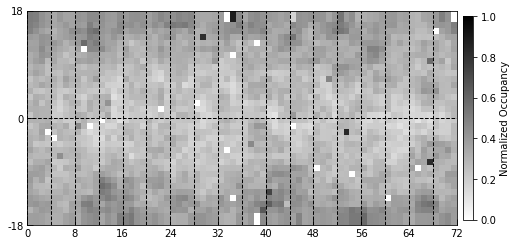

 >> AE-reco image:


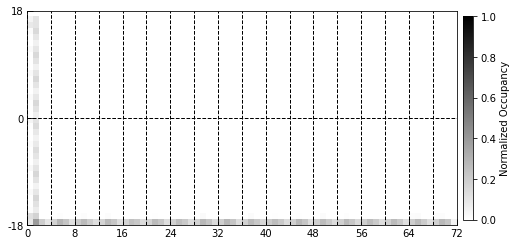

 >> loss map:


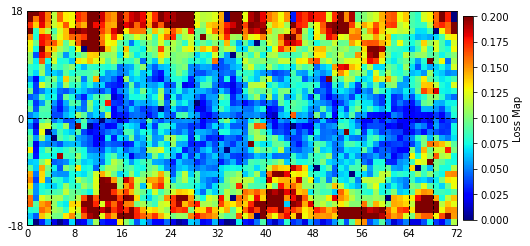

1: (0/32) Train loss:0.088507, Emax: 0.886000, Erecomax: 0.392351
1: Train time:0.06 min in 32 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


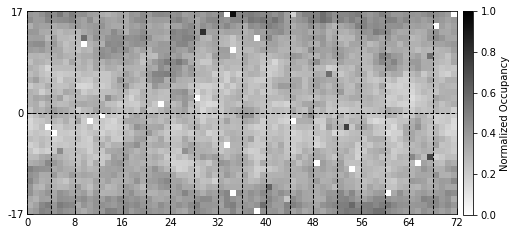

 >> AE-reco image:


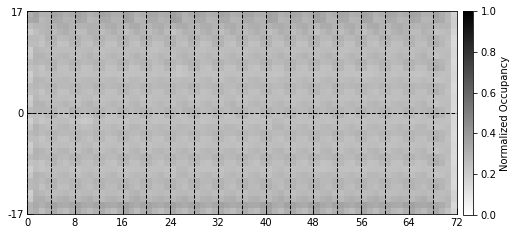

 >> loss map:


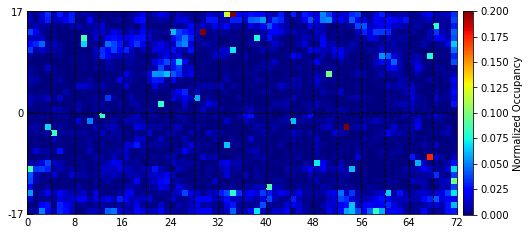

1: Val loss:0.007530, MAE: 0.066539, N samples: 200 in 0.031544 min
>> Validation: Anomaly samples <<<<<<<<
 >> original image:


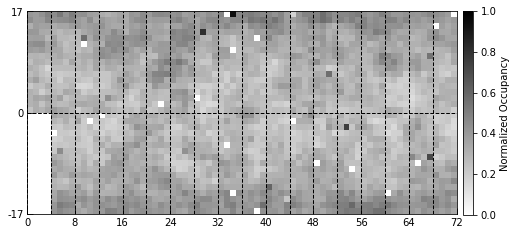

 >> AE-reco image:


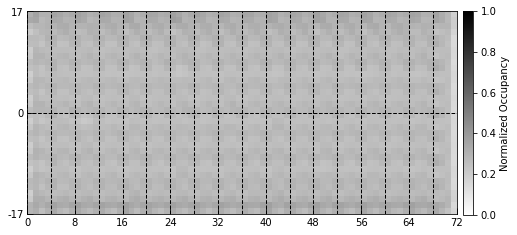

 >> loss map:


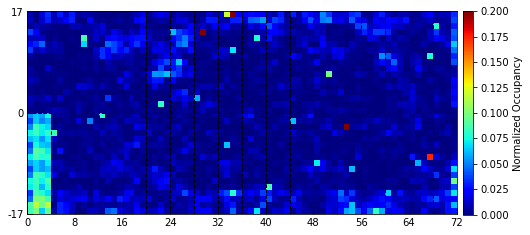

1: Val loss:0.009291, MAE: 0.071907, N samples: 200 in 0.023883 min
>> Epoch 2 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


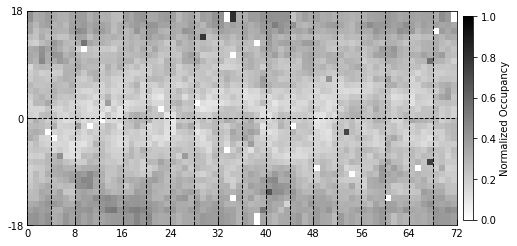

 >> AE-reco image:


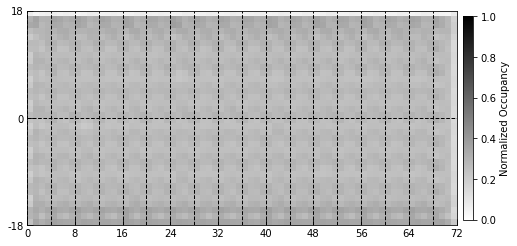

 >> loss map:


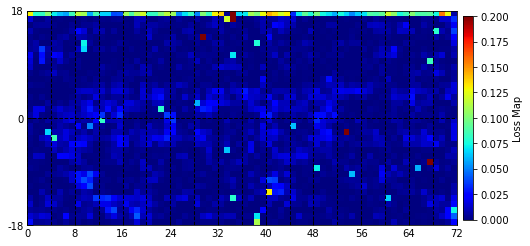

2: (0/32) Train loss:0.008709, Emax: 0.820000, Erecomax: 0.382044
2: Train time:0.06 min in 32 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


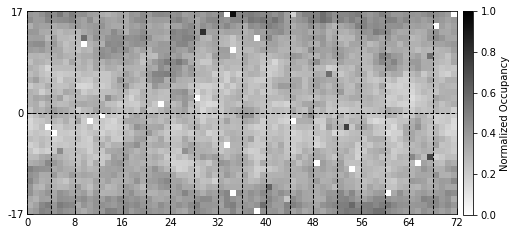

 >> AE-reco image:


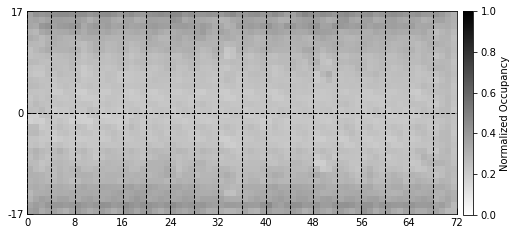

 >> loss map:


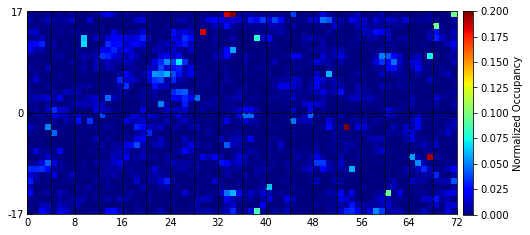

2: Val loss:0.005148, MAE: 0.053218, N samples: 200 in 0.027418 min
>> Validation: Anomaly samples <<<<<<<<
 >> original image:


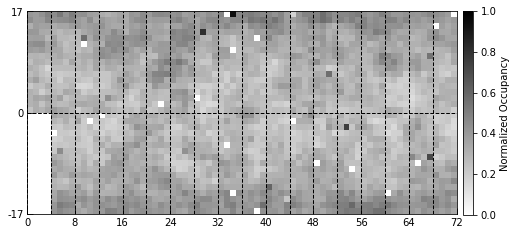

 >> AE-reco image:


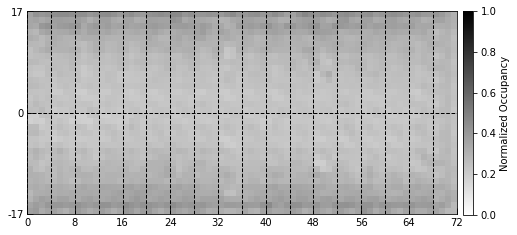

 >> loss map:


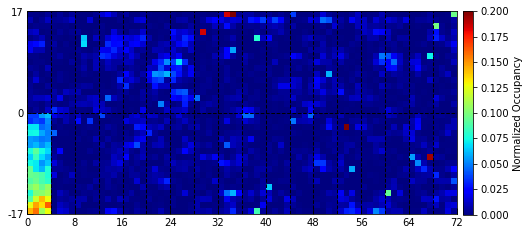

2: Val loss:0.007269, MAE: 0.059497, N samples: 200 in 0.028018 min
>> Epoch 3 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


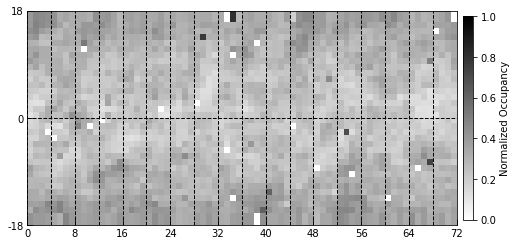

 >> AE-reco image:


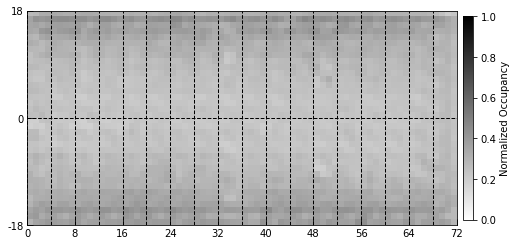

 >> loss map:


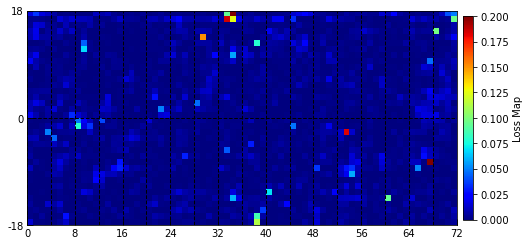

3: (0/32) Train loss:0.004530, Emax: 0.809000, Erecomax: 0.469723
3: Train time:0.05 min in 32 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


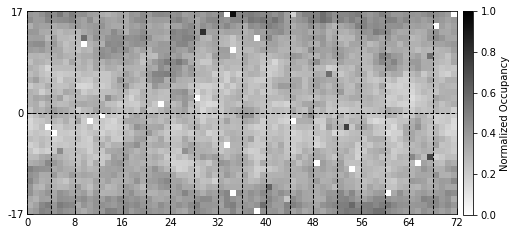

 >> AE-reco image:


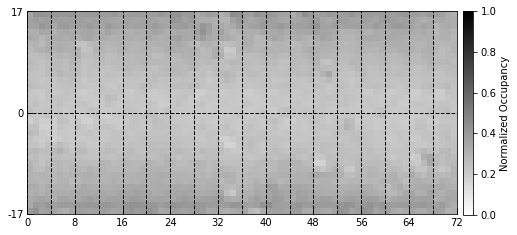

 >> loss map:


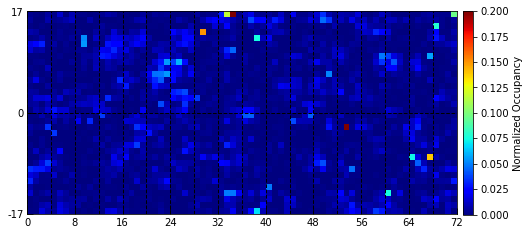

3: Val loss:0.004740, MAE: 0.051467, N samples: 200 in 0.026807 min
>> Validation: Anomaly samples <<<<<<<<
 >> original image:


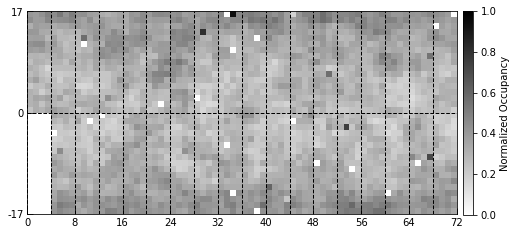

 >> AE-reco image:


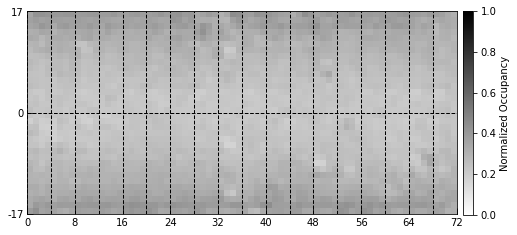

 >> loss map:


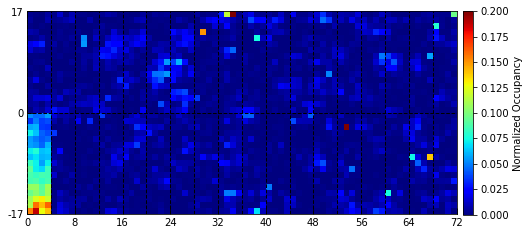

3: Val loss:0.006855, MAE: 0.057750, N samples: 200 in 0.027353 min
>> Epoch 4 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


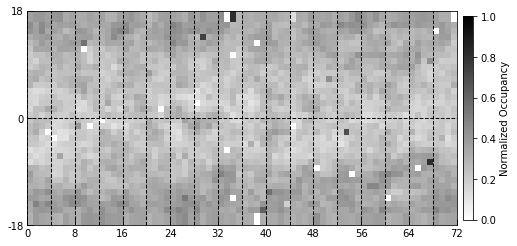

 >> AE-reco image:


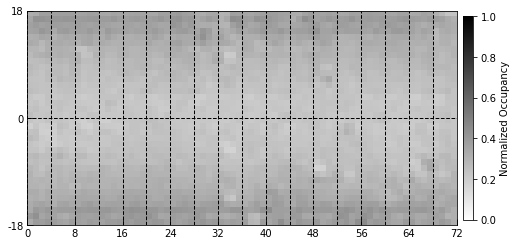

 >> loss map:


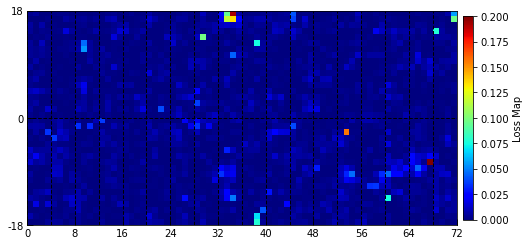

4: (0/32) Train loss:0.004098, Emax: 0.820000, Erecomax: 0.459813
4: Train time:0.06 min in 32 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


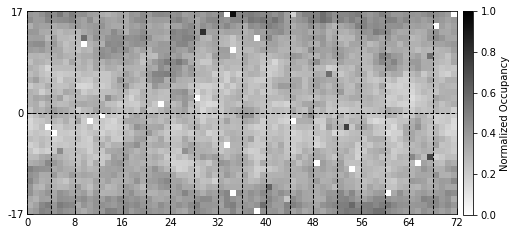

 >> AE-reco image:


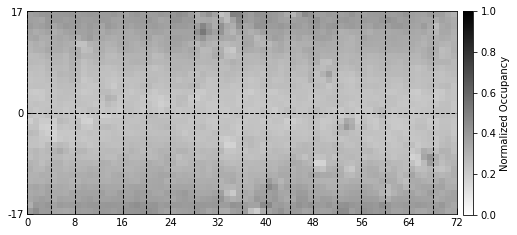

 >> loss map:


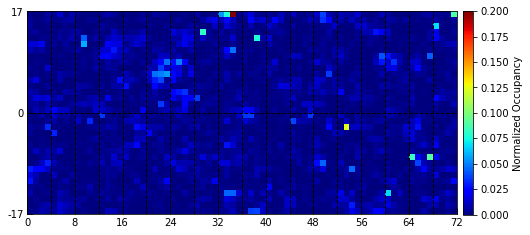

4: Val loss:0.003979, MAE: 0.047576, N samples: 200 in 0.029597 min
>> Validation: Anomaly samples <<<<<<<<
 >> original image:


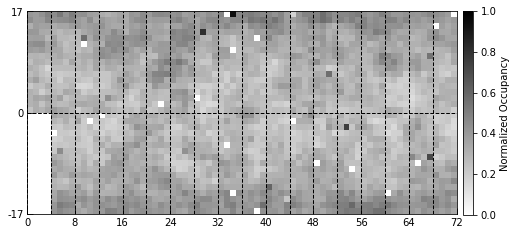

 >> AE-reco image:


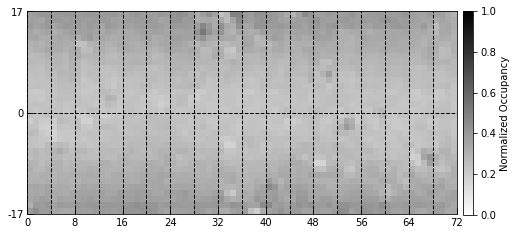

 >> loss map:


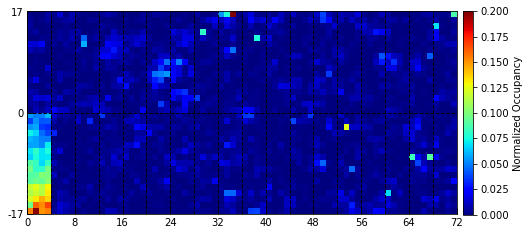

4: Val loss:0.006328, MAE: 0.054344, N samples: 200 in 0.028150 min
>> Epoch 5 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


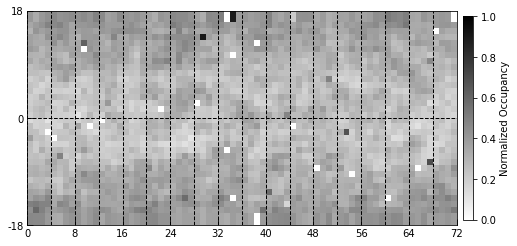

 >> AE-reco image:


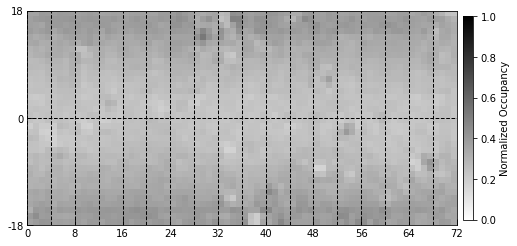

 >> loss map:


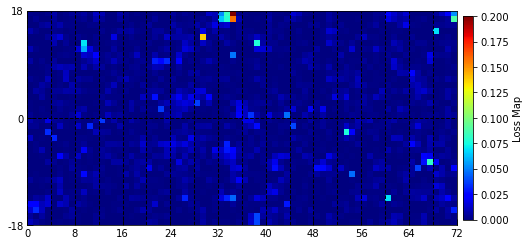

5: (0/32) Train loss:0.004042, Emax: 0.900000, Erecomax: 0.528952
5: Train time:0.05 min in 32 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


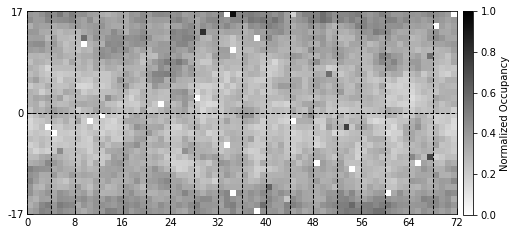

 >> AE-reco image:


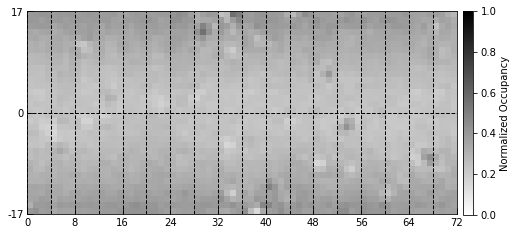

 >> loss map:


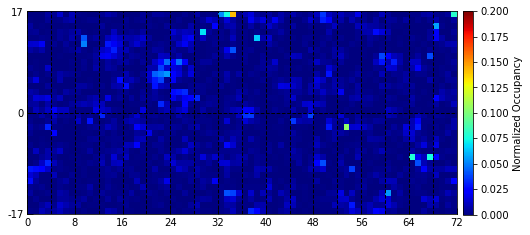

5: Val loss:0.003831, MAE: 0.047041, N samples: 200 in 0.027993 min
>> Validation: Anomaly samples <<<<<<<<
 >> original image:


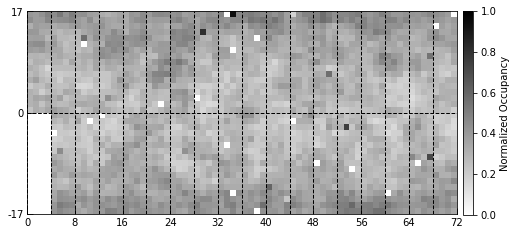

 >> AE-reco image:


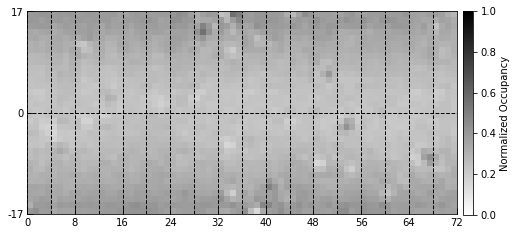

 >> loss map:


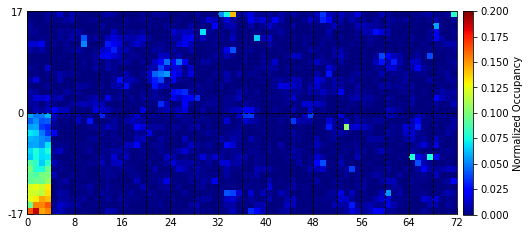

5: Val loss:0.006180, MAE: 0.053813, N samples: 200 in 0.025986 min
>> Epoch 6 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


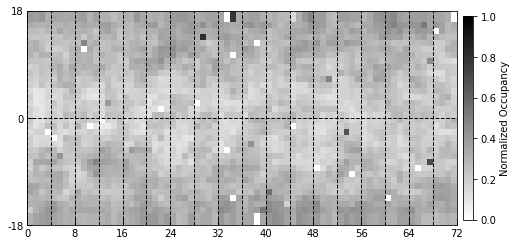

 >> AE-reco image:


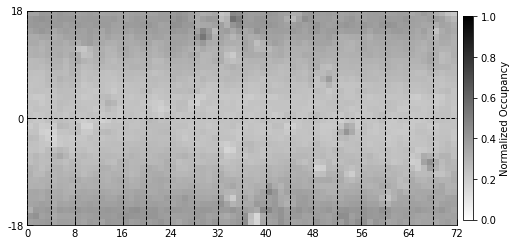

 >> loss map:


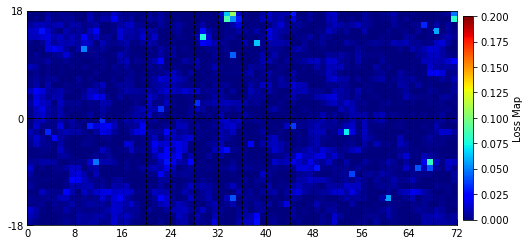

6: (0/32) Train loss:0.003911, Emax: 0.815000, Erecomax: 0.556754
6: Train time:0.06 min in 32 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


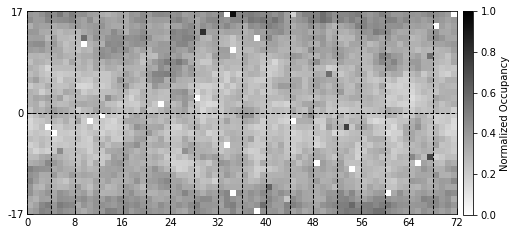

 >> AE-reco image:


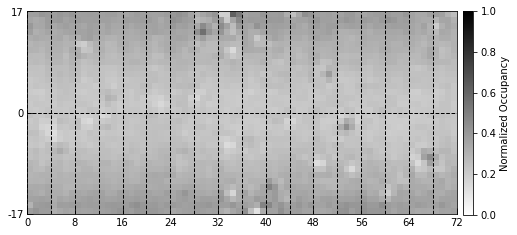

 >> loss map:


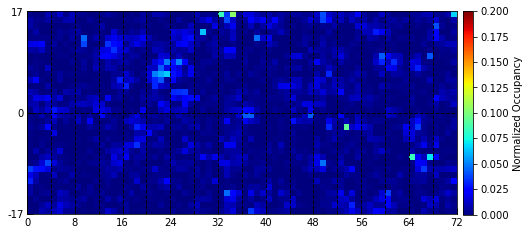

6: Val loss:0.004298, MAE: 0.050278, N samples: 200 in 0.025228 min
>> Validation: Anomaly samples <<<<<<<<
 >> original image:


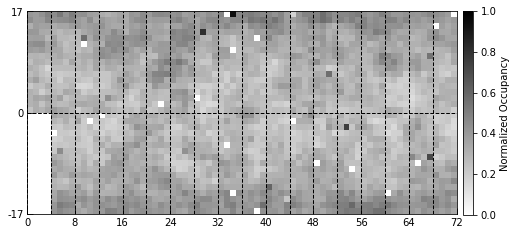

 >> AE-reco image:


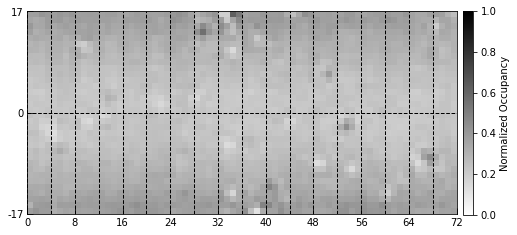

 >> loss map:


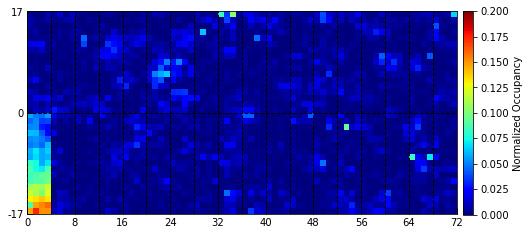

6: Val loss:0.006457, MAE: 0.056656, N samples: 200 in 0.027234 min
>> Epoch 7 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


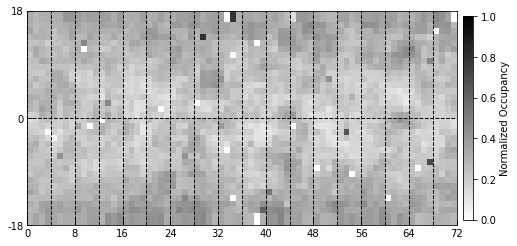

 >> AE-reco image:


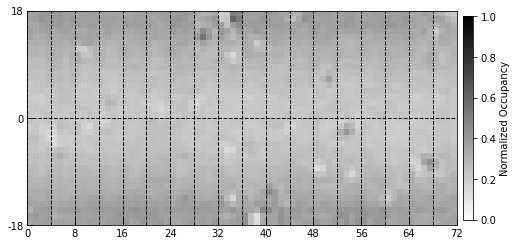

 >> loss map:


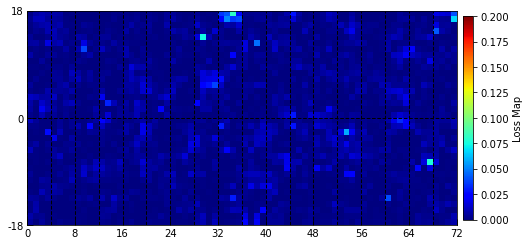

7: (0/32) Train loss:0.003588, Emax: 0.816000, Erecomax: 0.603177
7: Train time:0.05 min in 32 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


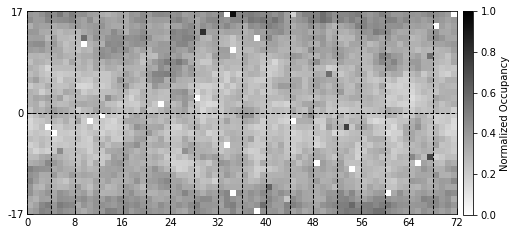

 >> AE-reco image:


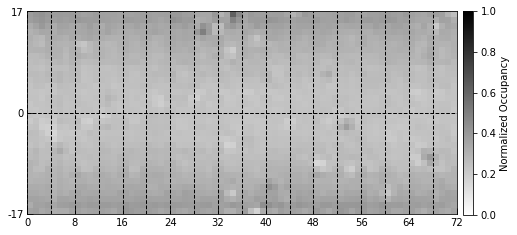

 >> loss map:


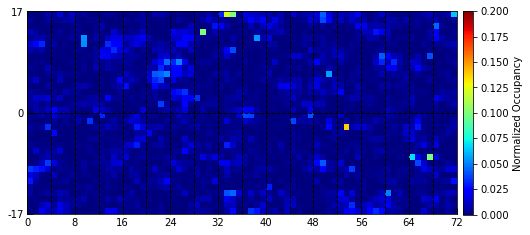

7: Val loss:0.004311, MAE: 0.049757, N samples: 200 in 0.027420 min
>> Validation: Anomaly samples <<<<<<<<
 >> original image:


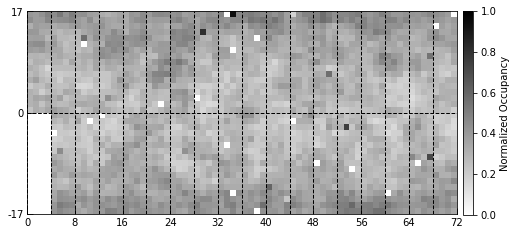

 >> AE-reco image:


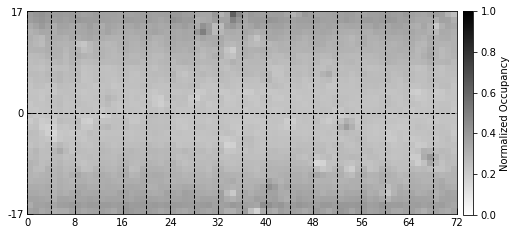

 >> loss map:


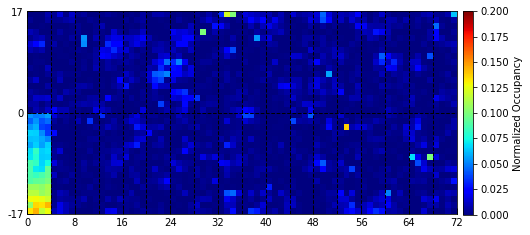

7: Val loss:0.006475, MAE: 0.056223, N samples: 200 in 0.026629 min
>> Epoch 8 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


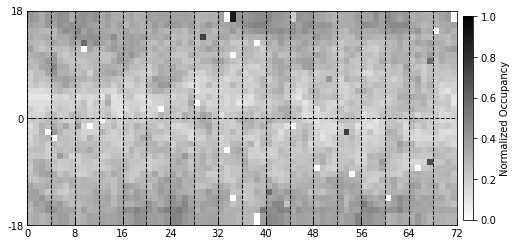

 >> AE-reco image:


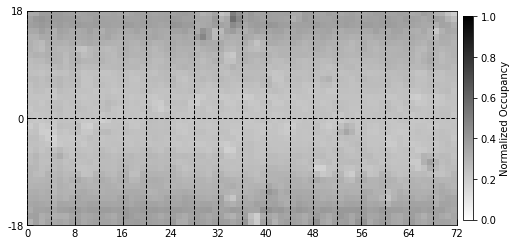

 >> loss map:


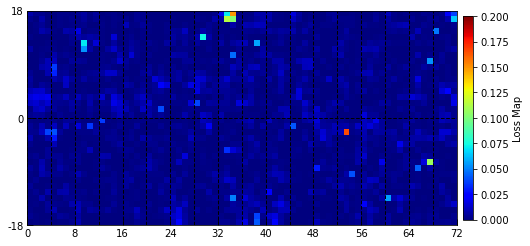

8: (0/32) Train loss:0.003888, Emax: 0.887000, Erecomax: 0.566189
8: Train time:0.05 min in 32 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


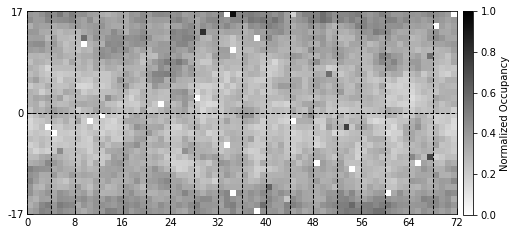

 >> AE-reco image:


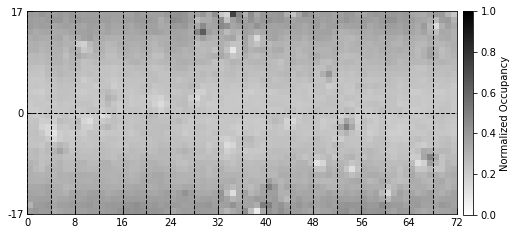

 >> loss map:


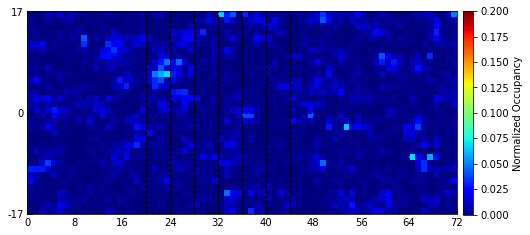

8: Val loss:0.004016, MAE: 0.048920, N samples: 200 in 0.028931 min
>> Validation: Anomaly samples <<<<<<<<
 >> original image:


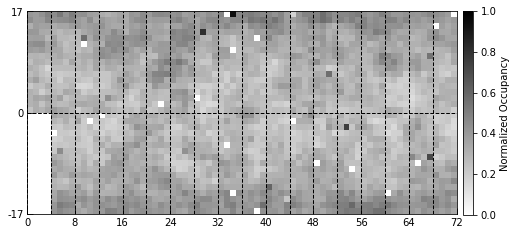

 >> AE-reco image:


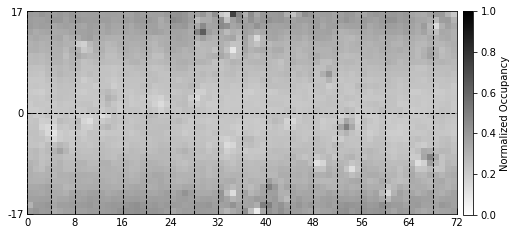

 >> loss map:


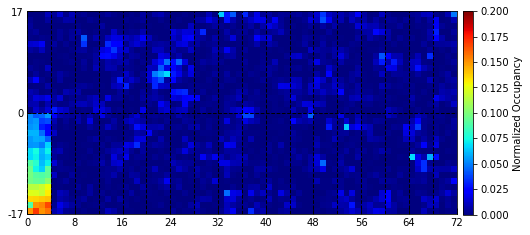

8: Val loss:0.006263, MAE: 0.055498, N samples: 200 in 0.025998 min
>> Epoch 9 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


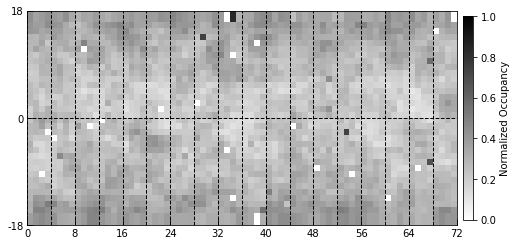

 >> AE-reco image:


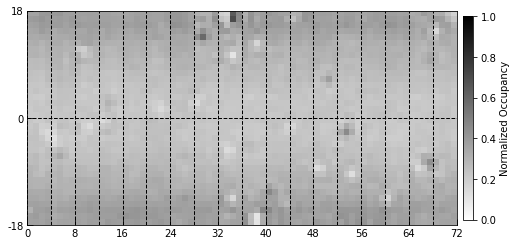

 >> loss map:


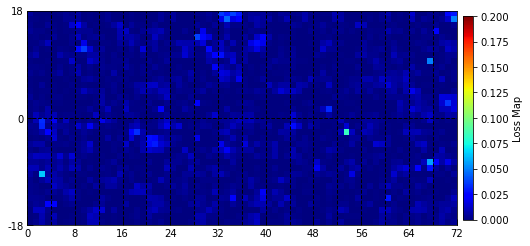

9: (0/32) Train loss:0.003367, Emax: 0.833000, Erecomax: 0.700702
9: Train time:0.05 min in 32 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


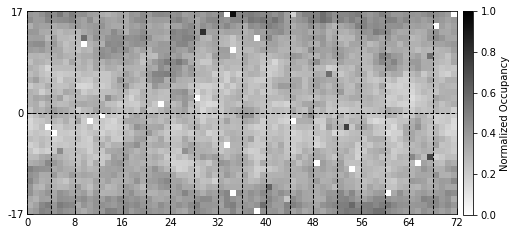

 >> AE-reco image:


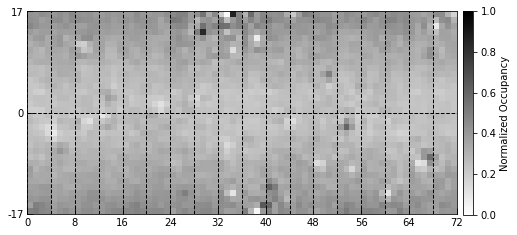

 >> loss map:


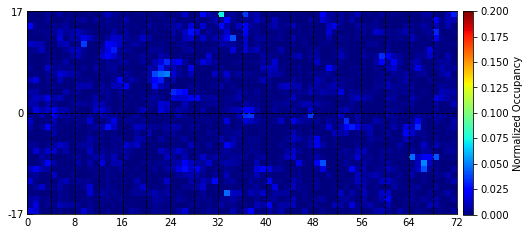

9: Val loss:0.003578, MAE: 0.047117, N samples: 200 in 0.028154 min
>> Validation: Anomaly samples <<<<<<<<
 >> original image:


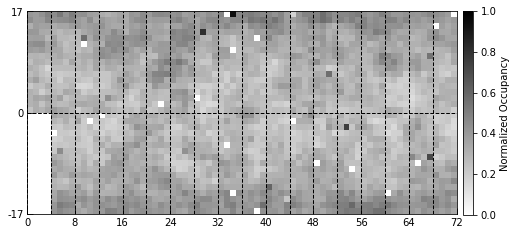

 >> AE-reco image:


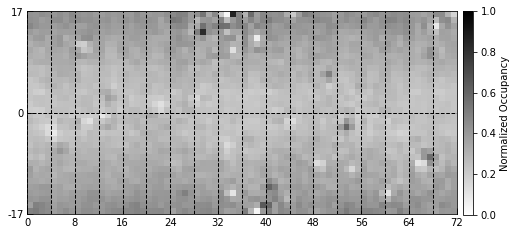

 >> loss map:


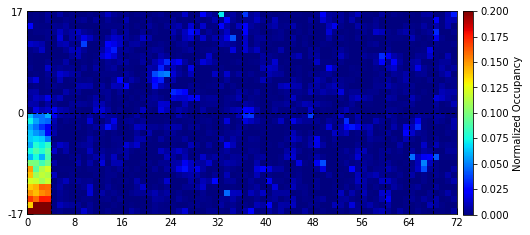

9: Val loss:0.006299, MAE: 0.054299, N samples: 200 in 0.028617 min
>> Epoch 10 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


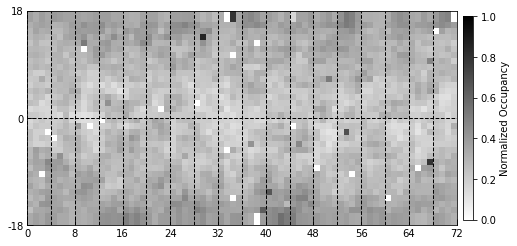

 >> AE-reco image:


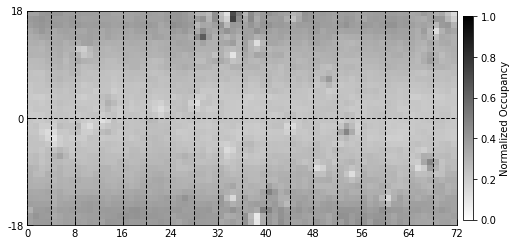

 >> loss map:


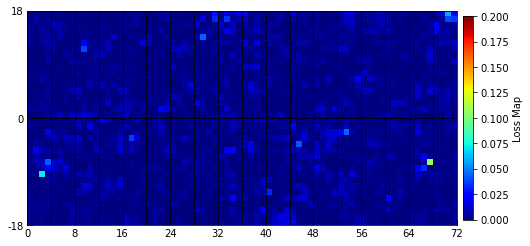

10: (0/32) Train loss:0.003223, Emax: 0.857000, Erecomax: 0.738835
10: Train time:0.07 min in 32 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


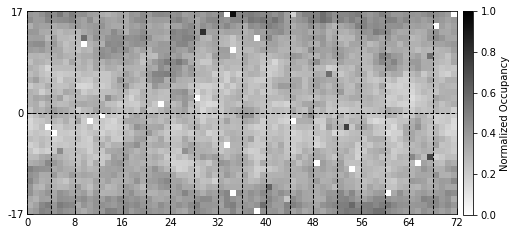

 >> AE-reco image:


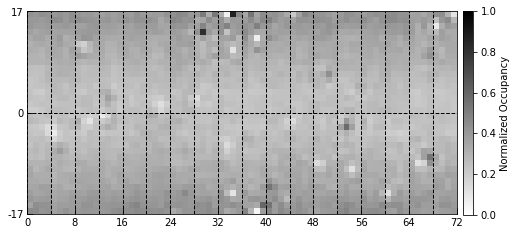

 >> loss map:


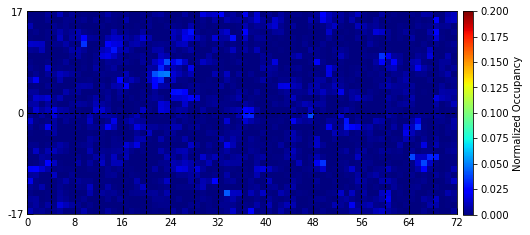

10: Val loss:0.003389, MAE: 0.045589, N samples: 200 in 0.027242 min
>> Validation: Anomaly samples <<<<<<<<
 >> original image:


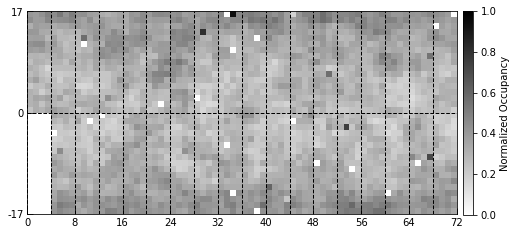

 >> AE-reco image:


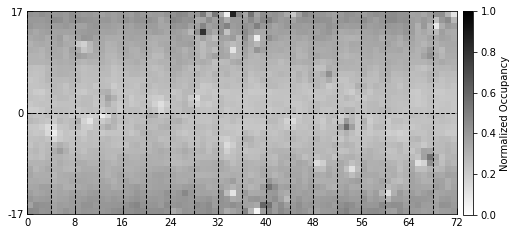

 >> loss map:


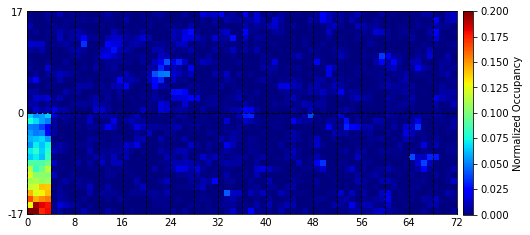

10: Val loss:0.005882, MAE: 0.052604, N samples: 200 in 0.033073 min


In [13]:
# Initialize AE model
#ae = ResNetAE(1, 3, [16, 32]) #down3
ae = ResNetAE(1, 3, [16, 32, 64]) #down4/5
ae.cuda()
# Initialize optimizer
optimizer = optim.Adam(ae.parameters(), lr=5.e-4)

epochs = 10
monitor_step = 2000
for e in range(epochs):

    epoch = e+1
    s = '>> Epoch %d <<<<<<<<'%(epoch)
    print(s)

    # Run training
    ae.train()
    print(">> Training <<<<<<<<")
    now = time.time()
    for i, data in enumerate(loader_train):
        X = data['EBOccupancyTask_EBOT_digi_occupancy'].cuda()
        # Reset gradient at each batch
        optimizer.zero_grad()
        # AE-reconstructed images
        Xreco = ae(X)
        # Batch-averaged loss
        loss = F.mse_loss(Xreco, X)
        '''
        For VAE:
        #Xreco, mu, logvar = ae(X)
        #loss, mse, kld = vae_loss(Xreco, X, mu, logvar)
        '''
        # Calculate backprop errors
        loss.backward()
        # Update network weights
        optimizer.step()
        # To monitor training progress during the epoch
        # explicity plot original and AE-reconstructed images for 0-th sample in every monitor_step batch
        # then plot the loss map
        if i % monitor_step == 0:
            # Original image:
            print(' >> original image:')
            img = X[0].cpu().numpy()
            plot_EB(img, extend_edge=True)
            # AE-reconstructed image
            print(' >> AE-reco image:')
            img_reco = Xreco[0].detach().cpu().numpy()
            plot_EB(img_reco, extend_edge=True)
            # Loss map
            print(' >> loss map:')
            img_loss = F.mse_loss(Xreco[0], X[0], reduction='none').detach().cpu().numpy()
            plot_EB(img_loss, vmax=0.2, cmap='jet', label='Loss Map', extend_edge=True)
            print('%d: (%d/%d) Train loss:%f, Emax: %f, Erecomax: %f'%(epoch, i, len(loader_train), loss.item(), img.max(), img_reco.max()))
        #break
    now = time.time() - now
    s = '%d: Train time:%.2f min in %d steps'%(epoch, now/60, len(loader_train))
    print(s)
    #'''
    # Run Validation
    ae.eval()
    print(">> Validation: Good samples <<<<<<<<")
    _ = do_eval(ae, loader_val, epoch)
    print(">> Validation: Anomaly samples <<<<<<<<")
    _ = do_eval(ae, loader_anom, epoch)
    # TODO: Make some plots showing rate of false positives, false negatives, etc.
    #'''